## Non Max Supression

In [8]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


In [9]:


# Hàm IoU
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [10]:
def nms(bboxes, iou_threshold, threshold, box_format="corners" ):
    # box = [class, score_prep, x,y,w,h]
    # Kiểm tra bboxes có phải kiểu list không
    assert type(bboxes) == list

    # Loại bỏ các box < threshold
    bboxes = [box for box in bboxes if box[1] > threshold]

    # Sắp xếp lại bboxes sao cho score_prep giảm dần
    bboxes = sorted(bboxes, key = lambda x: x[1], reverse = True)

    # Duyệt qua từng cặp box bên trong bboxes
    nms_bboxes = []
    while bboxes:
        box_chose = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != box_chose[0] or
            intersection_over_union(
                torch.tensor(box[2:])
                ,torch.tensor(box_chose[2:])
                , box_format = box_format) < iou_threshold
        ]

        nms_bboxes.append(box_chose)

    return nms_bboxes


IoU giữa các hộp dự đoán và hộp nhãn: [[[0.6806723]
  [0.5655577]
  [0.       ]]]
Hộp sau NMS: [[0, 0.9, 40, 40, 60, 60], [0, 0.7, 45, 45, 65, 65], [0, 0.6, 20, 20, 35, 35]]


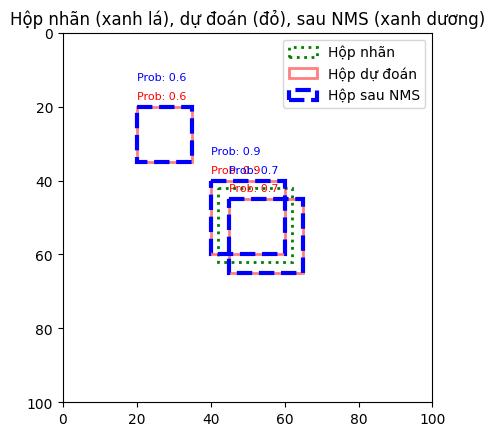

In [11]:
# Dữ liệu ví dụ
# Hộp dự đoán (bboxes)
bboxes = [
    [0, 0.9, 40, 40, 60, 60],  # Hộp 1: class=0, prob=0.9
    [0, 0.7, 45, 45, 65, 65],  # Hộp 2: class=0, prob=0.7
    [0, 0.6, 20, 20, 35, 35],  # Hộp 3: class=0, prob=0.6
]

# Hộp nhãn (dùng để minh họa IoU với hộp dự đoán)
boxes_labels = torch.tensor([[42, 42, 62, 62]], dtype=torch.float32)

# Tham số NMS
iou_threshold = 0.5
threshold = 0.5
box_format = "corners"

# Tính IoU giữa hộp dự đoán và hộp nhãn
boxes_preds = torch.tensor([[box[2:] for box in bboxes]], dtype=torch.float32)  # Lấy tọa độ từ bboxes
iou_with_labels = intersection_over_union(boxes_preds, boxes_labels, box_format="corners")
print("IoU giữa các hộp dự đoán và hộp nhãn:", iou_with_labels.numpy())

# Áp dụng NMS
bboxes_after_nms = nms(bboxes, iou_threshold, threshold, box_format)
print("Hộp sau NMS:", bboxes_after_nms)

# Tạo ảnh giả lập (100x100, màu trắng)
image = np.ones((100, 100, 3))  # Ảnh trắng RGB

# Tạo figure và axes
fig, ax = plt.subplots(1)
ax.imshow(image)  # Hiển thị ảnh

# Vẽ hộp nhãn (màu xanh lá, nét đứt)
x1, y1, x2, y2 = boxes_labels[0]
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='g', facecolor='none', linestyle=':', label='Hộp nhãn')
ax.add_patch(rect)

# Vẽ tất cả hộp dự đoán ban đầu (màu đỏ, nét liền)
for i, box in enumerate(bboxes):
    x1, y1, x2, y2 = box[2:]
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none', linestyle='-', alpha=0.5, label='Hộp dự đoán' if i == 0 else "")
    ax.add_patch(rect)
    ax.text(x1, y1-2, f'Prob: {box[1]}', color='r', fontsize=8)

# Vẽ hộp sau NMS (màu xanh dương, nét dày)
for i, box in enumerate(bboxes_after_nms):
    x1, y1, x2, y2 = box[2:]
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor='b', facecolor='none', linestyle='--', label='Hộp sau NMS' if i == 0 else "")
    ax.add_patch(rect)
    ax.text(x1, y1-7, f'Prob: {box[1]}', color='b', fontsize=8)

# Thiết lập trục và hiển thị
ax.set_xlim(0, 100)
ax.set_ylim(100, 0)  # Đảo ngược trục y để khớp hệ tọa độ ảnh
plt.title("Hộp nhãn (xanh lá), dự đoán (đỏ), sau NMS (xanh dương)")
plt.legend()
plt.show()